In [15]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


In [5]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
imdb_df = pd.read_csv('/kaggle/input/imdb-dataset/IMDB Dataset.csv')
print(imdb_df.head())
print(imdb_df.columns)


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Index(['review', 'sentiment'], dtype='object')


In [7]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and numbers (except word characters)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

# Apply preprocessing to all reviews
imdb_df['review'] = imdb_df['review'].apply(preprocess_text)


In [8]:
label_encoder = LabelEncoder()
imdb_df['sentiment'] = label_encoder.fit_transform(imdb_df['sentiment'])
# "positive" -> 1, "negative" -> 0


In [9]:
X = imdb_df['review']
y = imdb_df['sentiment']

# Split into train and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Set maximum number of words and sequence length
MAX_WORDS = 5000
MAX_SEQUENCE_LENGTH = 200

# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)


In [31]:
import numpy as np

# Load pre-trained GloVe embeddings
# print("Loading GloVe word embeddings...")
embeddings_index = {}
embedding_dim = 100  # Must match the dimension of the GloVe file you're using
glove_path = '/kaggle/input/glove-dataset/glove.6B.100d.txt'  # Update the path accordingly

with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

# Create embedding matrix
MAX_WORDS = 5000  # Should match the maximum number of words in your tokenizer
embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Embedding matrix created successfully.")


Found 400000 word vectors.
Embedding matrix created successfully.


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

EMBEDDING_DIM = 100  # This must match the dimension of GloVe used

model = Sequential()

# Embedding Layer with pre-trained GloVe weights
model.add(Embedding(input_dim=MAX_WORDS, 
                    output_dim=EMBEDDING_DIM, 
                    input_shape=(MAX_SEQUENCE_LENGTH,),
                    weights=[embedding_matrix],
                    trainable=True))  # Allow embedding fine-tuning

# Convolutional Layer for feature extraction
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))  # Dropout for regularization

# Bidirectional LSTM Layer for sequential data processing
model.add(Bidirectional(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2)))

# Dense layers for output
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
history = model.fit(X_train_pad, y_train, 
                    epochs=100, 
                    batch_size=32,  # Reduce batch size
                    validation_data=(X_test_pad, y_test),
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 384s 302ms/step - accuracy: 0.5807 - loss: 0.6589 - val_accuracy: 0.7902 - val_loss: 0.4766 - learning_rate: 1.0000e-04
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 373s 298ms/step - accuracy: 0.7739 - loss: 0.4873 - val_accuracy: 0.8280 - val_loss: 0.4007 - learning_rate: 1.0000e-04
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 373s 299ms/step - accuracy: 0.8095 - loss: 0.4267 - val_accuracy: 0.8397 - val_loss: 0.3840 - learning_rate: 1.0000e-04
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 374s 299ms/step - accuracy: 0.8331 - loss: 0.3863 - val_accuracy: 0.8530 - val_loss: 0.3528 - learning_rate: 1.0000e-04
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 374s 299ms/step - accuracy: 0.8512 - loss: 0.3551 - val_accuracy: 0.8651 - val_loss: 0.3370 - learning_rate: 1.0000e-04
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 374s 299ms/step - accuracy: 0.8635 - loss: 0.3242 - val_accuracy: 0.8705 - val_loss: 0.3222 - learning_rate: 1.0000e-04
Epoch 7/100
1250/1250 

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 93ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.91      0.89      4961
    Positive       0.90      0.87      0.88      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [34]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Extract TN, FP, FN, TP from Confusion Matrix
tn, fp, fn, tp = cm.ravel()

# Calculate Sensitivity and Specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")


Sensitivity (Recall): 0.87
Specificity: 0.91


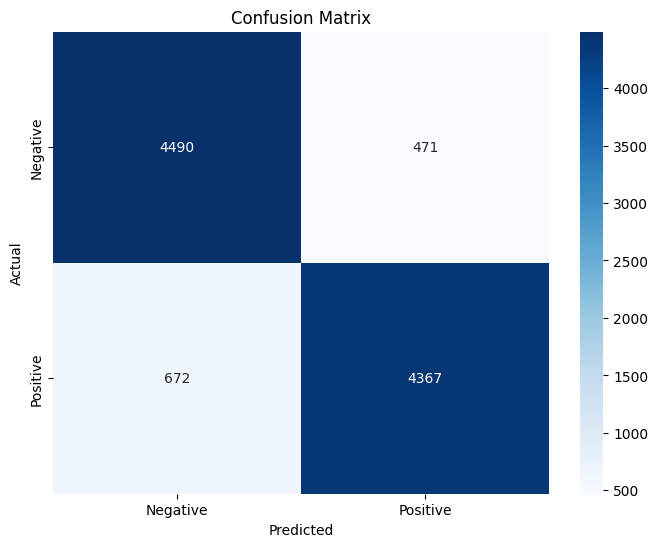

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


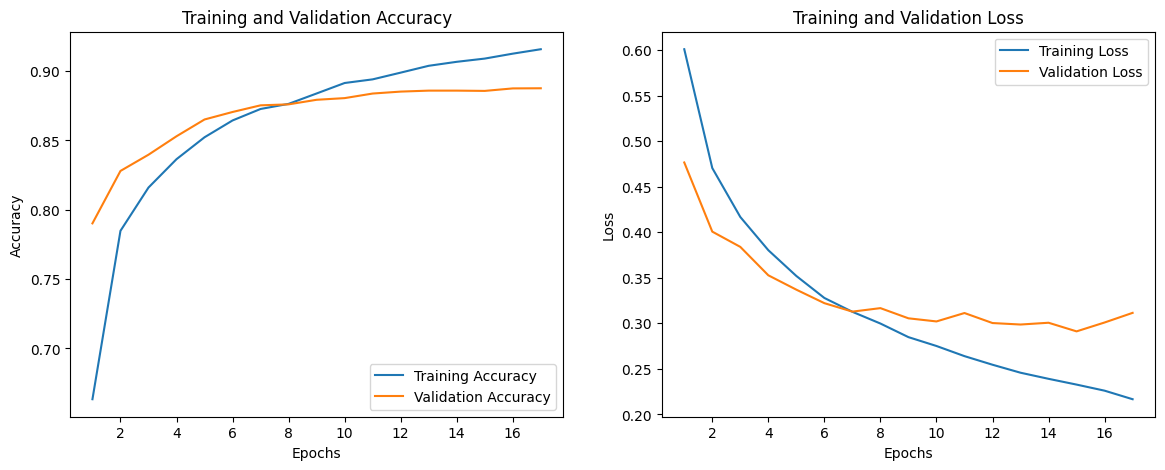

In [36]:
# Plotting the Training and Validation Accuracy and Loss Curves
epochs_range = range(1, len(history.history['accuracy']) + 1)

# Accuracy Curve
plt.figure(figsize=(14, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


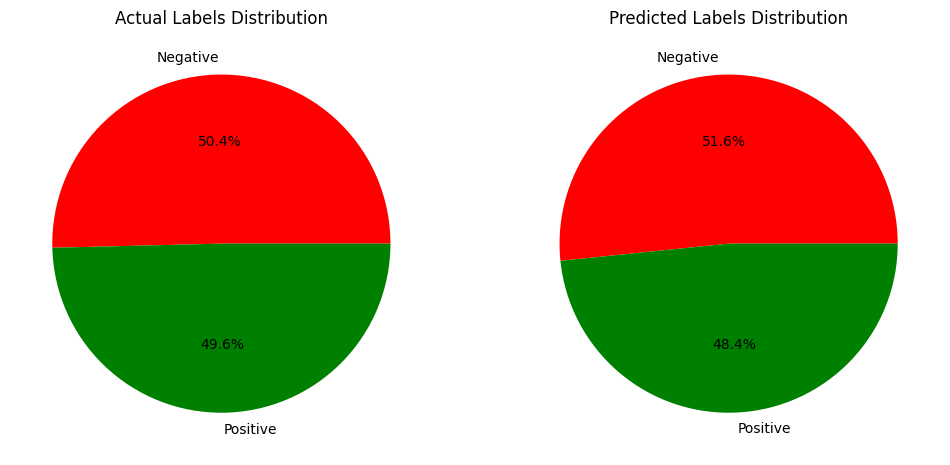

In [37]:
# Plotting Pie Charts for Actual vs Predicted Labels
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Actual Labels Pie Chart
axes[0].pie(y_test.value_counts(), labels=['Negative', 'Positive'], autopct='%1.1f%%', colors=['red', 'green'])
axes[0].set_title('Actual Labels Distribution')

# Predicted Labels Pie Chart
axes[1].pie(pd.Series(y_pred.flatten()).value_counts(), labels=['Negative', 'Positive'], autopct='%1.1f%%', colors=['red', 'green'])
axes[1].set_title('Predicted Labels Distribution')

plt.show()


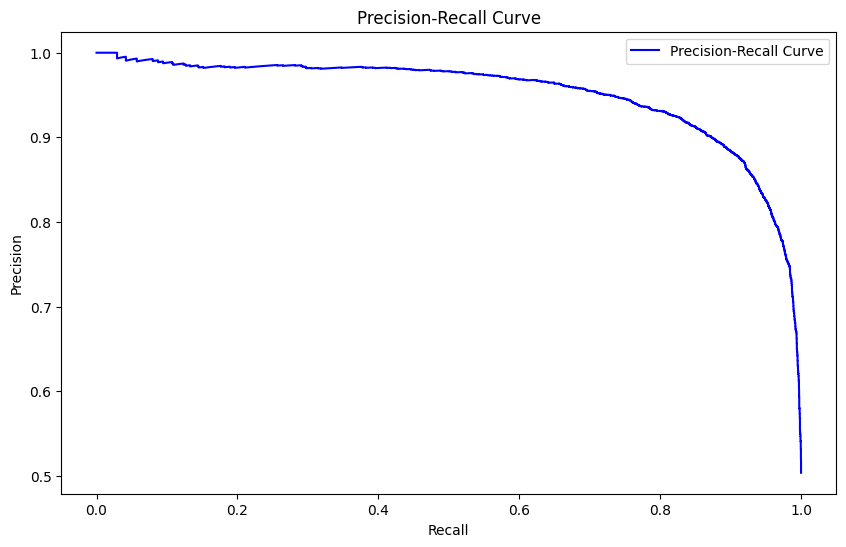

In [38]:
from sklearn.metrics import precision_recall_curve

# Calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='b', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


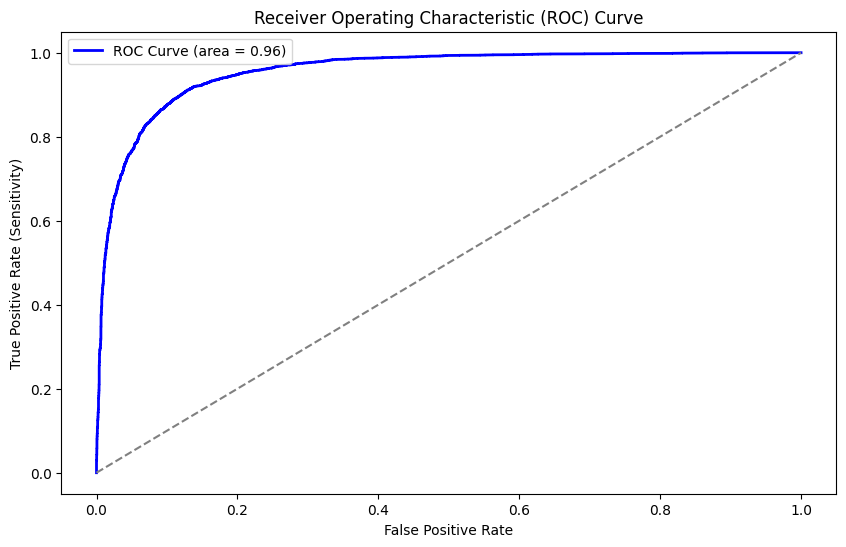

In [39]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define LSTM-only model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
lstm_model.add(LSTM(100, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
lstm_history = lstm_model.fit(X_train_pad, y_train, 
                              epochs=10, 
                              batch_size=64, 
                              validation_data=(X_test_pad, y_test),
                              verbose=1)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6536 - loss: 0.6133 - val_accuracy: 0.8681 - val_loss: 0.3200
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8803 - loss: 0.3031 - val_accuracy: 0.8834 - val_loss: 0.2848
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9050 - loss: 0.2511 - val_accuracy: 0.8814 - val_loss: 0.2853
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9141 - loss: 0.2336 - val_accuracy: 0.8825 - val_loss: 0.2827
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9192 - loss: 0.2200 - val_accuracy: 0.8797 - val_loss: 0.2994
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9232 - loss: 0.2092 - val_accuracy: 0.8819 - val_loss: 0.3001
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9283 - loss: 0.2004 - val_accuracy: 0.8766 - val_loss: 0.3068
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9317 - loss: 0.1892 - val_accurac

In [41]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Define CNN-only model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn_history = cnn_model.fit(X_train_pad, y_train, 
                            epochs=10, 
                            batch_size=64, 
                            validation_data=(X_test_pad, y_test),
                            verbose=1)


Epoch 1/10


I0000 00:00:1728550910.155958     122 service.cc:145] XLA service 0x7cc734564fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728550910.156023     122 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 43/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5088 - loss: 0.6931

I0000 00:00:1728550913.695677     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5481 - loss: 0.6748 - val_accuracy: 0.8680 - val_loss: 0.3157
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8788 - loss: 0.3052 - val_accuracy: 0.8859 - val_loss: 0.2701
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9084 - loss: 0.2461 - val_accuracy: 0.8887 - val_loss: 0.2663
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9194 - loss: 0.2182 - val_accuracy: 0.8865 - val_loss: 0.2787
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9285 - loss: 0.2029 - val_accuracy: 0.8845 - val_loss: 0.2782
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9337 - loss: 0.1877 - val_accuracy: 0.8829 - val_loss: 0.2877
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9405 - loss: 0.1776 - val_accuracy: 0.8790 - val_loss: 0.3010
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9466 - loss: 0.1623 - val_accuracy: 0.8796 - val_

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# TF-IDF Vectorizer and Logistic Regression Pipeline
tfidf_lr_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('lr', LogisticRegression(max_iter=1000))
])

# Train the TF-IDF + Logistic Regression model
tfidf_lr_model.fit(X_train, y_train)

# Predict and evaluate the performance
y_pred_lr = tfidf_lr_model.predict(X_test)

# Print the classification report
print("Logistic Regression with TF-IDF Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Negative', 'Positive']))


Logistic Regression with TF-IDF Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.87      0.88      4961
    Positive       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [44]:
from sklearn.metrics import classification_report


# Step 1: Generate Predictions
# CNN-LSTM Hybrid Model
y_pred_cnn_lstm = (model.predict(X_test_pad) > 0.5).astype(int)

# LSTM-Only Model
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype(int)

# CNN-Only Model
y_pred_cnn = (cnn_model.predict(X_test_pad) > 0.5).astype(int)

# Logistic Regression with TF-IDF
y_pred_lr = tfidf_lr_model.predict(X_test)

# Step 2: Generate Classification Reports
print("Classification Report for CNN-LSTM Hybrid Model:")
print(classification_report(y_test, y_pred_cnn_lstm, target_names=['Negative', 'Positive']))

print("\nClassification Report for LSTM-Only Model:")
print(classification_report(y_test, y_pred_lstm, target_names=['Negative', 'Positive']))

print("\nClassification Report for CNN-Only Model:")
print(classification_report(y_test, y_pred_cnn, target_names=['Negative', 'Positive']))

print("\nClassification Report for Logistic Regression with TF-IDF Model:")
print(classification_report(y_test, y_pred_lr, target_names=['Negative', 'Positive']))


313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report for CNN-LSTM Hybrid Model:
              precision    recall  f1-score   support

    Negative       0.87      0.91      0.89      4961
    Positive       0.90      0.87      0.88      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Classification Report for LSTM-Only Model:
              precision    recall  f1-score   support

    Negative       0.89      0.86      0.87      4961
    Positive       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Classification Report for CNN-Only Model:
              precision    recall  f1-score   support

    Negative       0.87      0

In [43]:
!pip install lime shap


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense

# Define a model without dropout layers
model_no_dropout = Sequential()
model_no_dropout.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_no_dropout.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model_no_dropout.add(MaxPooling1D(pool_size=2))
model_no_dropout.add(LSTM(50, return_sequences=True))
model_no_dropout.add(LSTM(50))
model_no_dropout.add(Dense(64, activation='relu'))
model_no_dropout.add(Dense(1, activation='sigmoid'))

# Compile the model
model_no_dropout.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model without dropout
no_dropout_history = model_no_dropout.fit(X_train_pad, y_train, 
                                          epochs=10, 
                                          batch_size=64, 
                                          validation_data=(X_test_pad, y_test),
                                          verbose=1)

# Generate classification report
y_pred_no_dropout = (model_no_dropout.predict(X_test_pad) > 0.5).astype(int)
print("Classification Report for Hybrid Model without Dropout:")
print(classification_report(y_test, y_pred_no_dropout, target_names=['Negative', 'Positive']))


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6867 - loss: 0.5682 - val_accuracy: 0.8728 - val_loss: 0.3044
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8949 - loss: 0.2683 - val_accuracy: 0.8822 - val_loss: 0.2845
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9115 - loss: 0.2331 - val_accuracy: 0.8828 - val_loss: 0.2863
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9244 - loss: 0.2054 - val_accuracy: 0.8798 - val_loss: 0.2879
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9332 - loss: 0.1884 - val_accuracy: 0.8805 - val_loss: 0.3001
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9454 - loss: 0.1640 - val_accuracy: 0.8754 - val_loss: 0.3138
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9605 - loss: 0.1312 - val_accuracy: 0.8741 - val_loss: 0.3393
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9754 - loss: 0.0917 - val_accurac

In [47]:
!pip install scikeras


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 83.9 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.


In [52]:
# Define a list of hyperparameter combinations
filters_list = [32, 64, 128]
lstm_units_list = [25, 50, 100]
learning_rate_list = [0.001, 0.0005, 0.0001]

best_accuracy = 0
best_params = {}

for filters in filters_list:
    for lstm_units in lstm_units_list:
        for learning_rate in learning_rate_list:
            # Create and compile model
            model = create_model(filters=filters, lstm_units=lstm_units, learning_rate=learning_rate)
            
            # Train the model
            history = model.fit(X_train_pad, y_train,
                                epochs=5, 
                                batch_size=64, 
                                validation_data=(X_test_pad, y_test),
                                verbose=0)

            # Evaluate the model
            loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
            print(f"Filters: {filters}, LSTM Units: {lstm_units}, Learning Rate: {learning_rate} => Accuracy: {accuracy:.4f}")

            # Track best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'filters': filters,
                    'lstm_units': lstm_units,
                    'learning_rate': learning_rate
                }

print("Best Hyperparameters:", best_params)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Filters: 32, LSTM Units: 25, Learning Rate: 0.001 => Accuracy: 0.8737
Filters: 32, LSTM Units: 25, Learning Rate: 0.0005 => Accuracy: 0.8755
Filters: 32, LSTM Units: 25, Learning Rate: 0.0001 => Accuracy: 0.8757
Filters: 32, LSTM Units: 50, Learning Rate: 0.001 => Accuracy: 0.8738
Filters: 32, LSTM Units: 50, Learning Rate: 0.0005 => Accuracy: 0.8679
Filters: 32, LSTM Units: 50, Learning Rate: 0.0001 => Accuracy: 0.8764
Filters: 32, LSTM Units: 100, Learning Rate: 0.001 => Accuracy: 0.8725
Filters: 32, LSTM Units: 100, Learning Rate: 0.0005 => Accuracy: 0.8719
Filters: 32, LSTM Units: 100, Learning Rate: 0.0001 => Accuracy: 0.8719
Filters: 64, LSTM Units: 25, Learning Rate: 0.001 => Accuracy: 0.8721
Filters: 64, LSTM Units: 25, Learning Rate: 0.0005 => Accuracy: 0.8749
Filters: 64, LSTM Units: 25, Learning Rate: 0.0001 => Accuracy: 0.8783
Filters: 64, LSTM Units: 50, Learning Rate: 0.001 => Accuracy: 0.8734
Filters: 64, LSTM Units: 50, Learning Rate: 0.0005 => Accuracy: 0.8744
Filters: